In [1]:
# Imports
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.layers import LSTM, Dense, TimeDistributed, RepeatVector

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder

/kaggle/input/air-quality-dataset/Air Quality.csv


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
### Load Dataset
DATA_PATH = "/kaggle/input/air-quality-dataset/Air Quality.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


### Preprocess Data

In [3]:
### Drop unwanted columns

# I will use all availaable features to predict temperature for the next n hours, let the DL model implicitly perform feature selection.
df.drop(columns = df.columns[-2:], axis = 1, inplace = True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# Description 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [5]:
# Description 2
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [6]:
# Column wise
df[df != -200].isna().sum()

Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64

In [7]:
# Drop noise

# There is min value of -200 on all the features which indicates something is wrong, I will drop all those values for now along with null values.
df.drop(columns = ["NMHC(GT)"], inplace = True)
df = df[df != -200].dropna().reset_index()
df.describe()

,index,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6941.00000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000,6941.000000
mean,4831.76113,2.182467,1119.913269,10.554488,958.543005,250.671949,816.893387,113.874082,1452.648898,1057.756519,17.755323,48.881905,0.985573
std,2835.99290,1.441158,218.733754,7.465226,264.055002,208.611371,251.897200,47.475017,353.301576,406.509957,8.844909,17.433193,0.401097
min,0.00000,0.100000,647.000000,0.200000,390.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,2315.00000,1.100000,956.000000,4.900000,760.000000,103.000000,642.000000,79.000000,1207.000000,760.000000,11.200000,35.300000,0.694100
50%,5075.00000,1.900000,1085.000000,8.800000,931.000000,186.000000,786.000000,110.000000,1457.000000,1006.000000,16.800000,49.200000,0.953900
75%,7392.00000,2.900000,1254.000000,14.600000,1135.000000,335.000000,947.000000,142.000000,1683.000000,1322.000000,23.700000,62.200000,1.251600
max,9356.00000,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


In [8]:
# Move the target column to the last index
target_col = df.pop('T')
df.insert(len(df.columns), 'T', target_col)
df.drop(columns = ['Date', 'index'], inplace = True)
df.head()

,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,13.6
1,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,13.3
2,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,11.9
3,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,11.0
4,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,11.2


In [9]:
# Scale & Encode the data for numerical stability
label_encoder = LabelEncoder()
df['Time'] = label_encoder.fit_transform(df['Time'])

# Select numerical columns
numerical_columns = df.select_dtypes(include = ['int', 'float']).columns

# Perform standard scaling
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,0.877653,0.289742,1.097700,0.180250,0.331231,-0.405913,0.949291,-0.018413,0.677518,0.517229,0.001038,-0.567916,-0.469832
1,1.024422,-0.126620,0.786797,-0.154660,-0.013419,-0.707932,1.417770,-0.460783,0.301042,-0.210973,-0.067801,-0.648451,-0.503752
2,1.171191,0.012167,1.289728,-0.208246,-0.074016,-0.573701,1.282785,0.002653,0.289720,0.039961,0.293605,-0.586865,-0.662047
3,1.317960,0.012167,1.170853,-0.181453,-0.039930,-0.377149,1.092217,0.171174,0.371809,0.357320,0.637800,-0.495858,-0.763808
4,1.464728,-0.404195,0.695355,-0.543156,-0.464115,-0.573701,1.540845,0.044783,0.105728,0.128526,0.614854,-0.490622,-0.741194


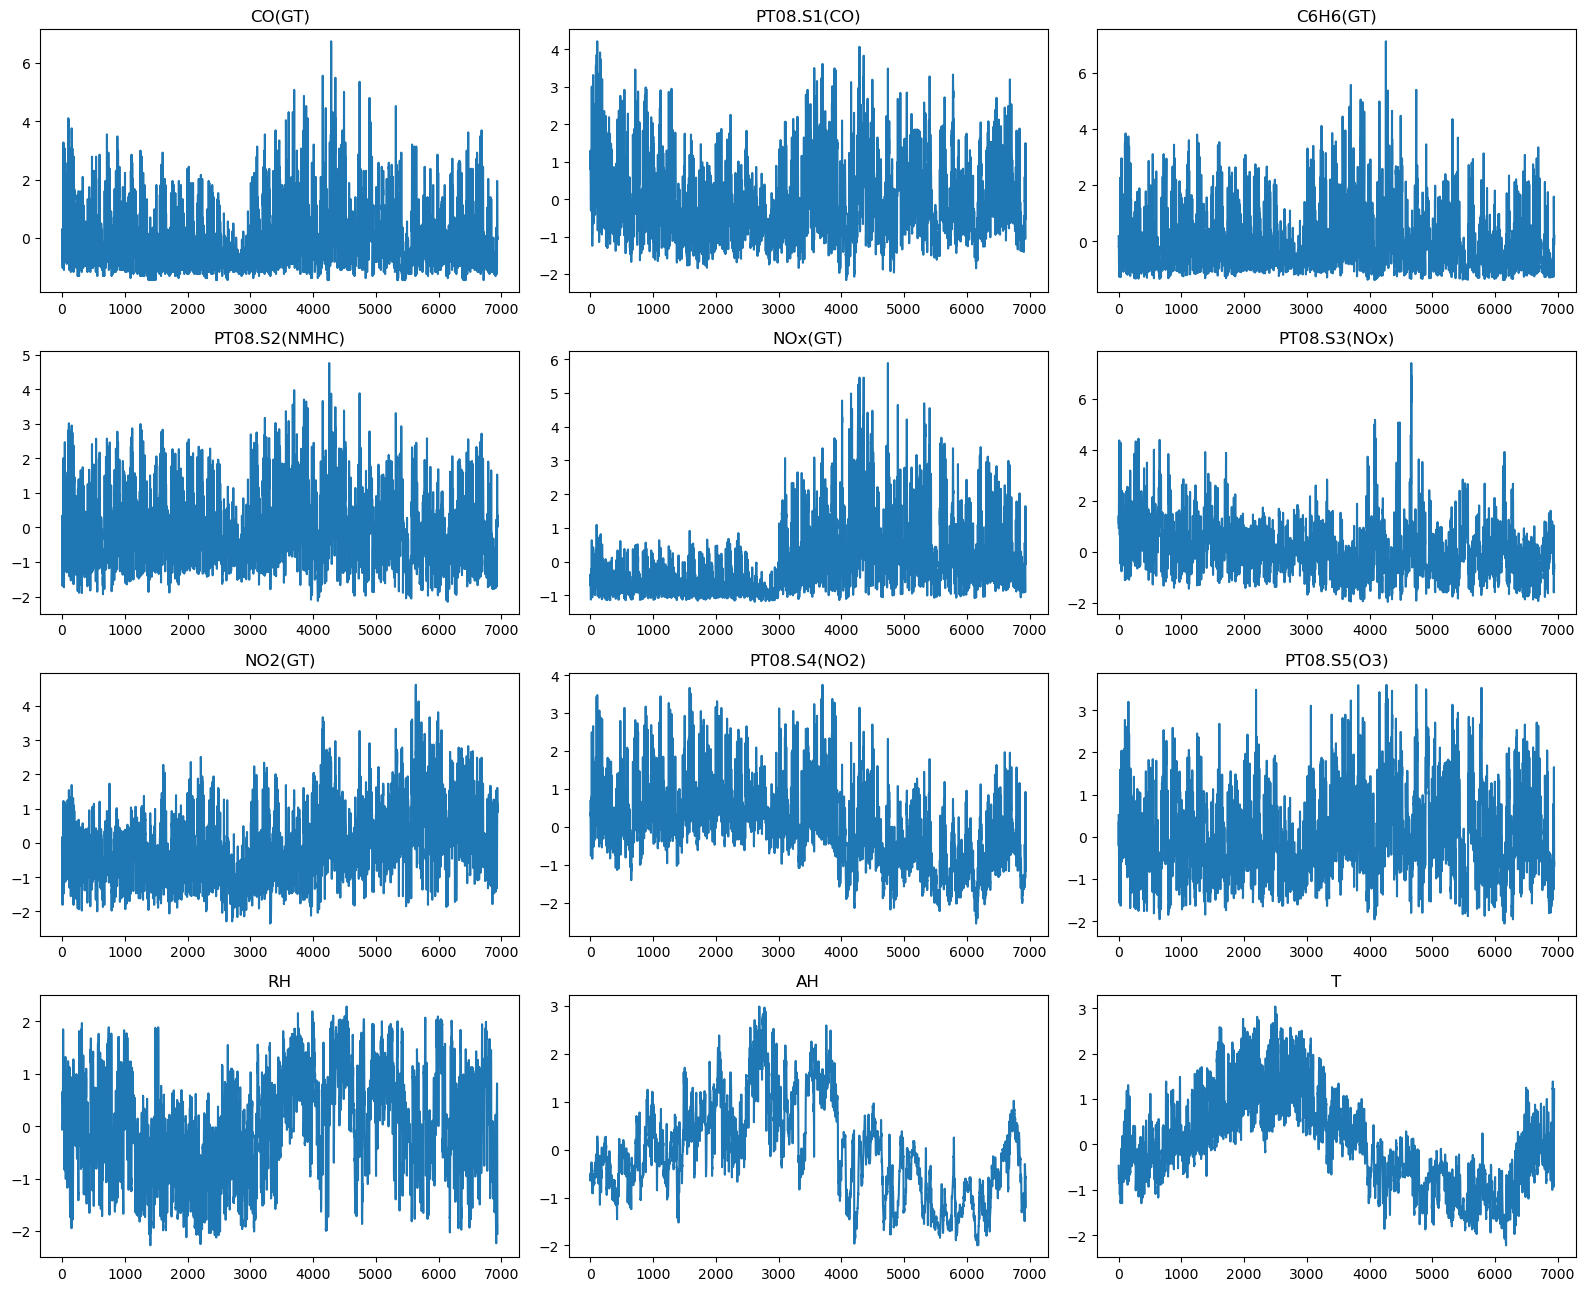

In [10]:
# Plots for each feature
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (16, 16))
axes = axes.flatten()

for i, column in enumerate(df.drop(columns = ['Time']).columns):
    axes[i].plot(df[column])
    axes[i].set_title(column)

if len(df.columns) - 1 < len(axes):
    for j in range(len(df.columns) - 1, len(axes)):
        fig.delaxes(axes[j])

# Adjust subplot spacing
fig.tight_layout()

# Show the plot
plt.show()

In [11]:
# Sliding Windows for LSTM
def sliding_window(dataframe, n_steps_in, n_steps_out):
    """
    dataframe - Pandas dataframe containing the rows and columns
    n_steps_in - Number of time steps used for prediction
    n_steps_out - Number of time steps to predict
    """
    
    # Local variables
    X, y = list(), list()
    
    for i in range(len(dataframe)):
        # Calculate indexes
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out - 1
        
        # Exit condition
        if out_end_idx > len(dataframe): break
        
        # Slice sequence
        seq_x, seq_y = dataframe.iloc[i:end_idx, :], dataframe.iloc[end_idx - 1:out_end_idx, -1]
        
        X.append(seq_x)
        y.append(seq_y)
            
    return np.array(X), np.array(y)

In [12]:
# Step parameters
n_steps_in = 1024
n_steps_out = 24
n_features = len(df.columns) 

# Split data into train and test
train_size = int(len(df) * 0.75)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size - n_steps_in:].reset_index(drop = True) # Adjusting test size to account for lost steps.

train_X, train_y = sliding_window(train_df, n_steps_in, n_steps_out)
test_X, test_y = sliding_window(test_df, n_steps_in, n_steps_out)


# Verify Shapes for LSTM model
print("Train X: ",train_X.shape)
print("Train Y: ",train_y.shape)
print("Test X: ",test_X.shape)
print("Test Y: ",test_y.shape)

Train X:  (4159, 1024, 13)
Train Y:  (4159, 24)
Test X:  (1714, 1024, 13)
Test Y:  (1714, 24)


### Modeling

#### 1) Vector Output Method - Multivariate Multi Input (No Parallel) Multistep Model

In [13]:
# Build
model = Sequential()
model.add(LSTM(units = 512, input_shape = (n_steps_in, n_features), dropout = 0.4, return_sequences = True))
model.add(LSTM(units = 256, dropout = 0.4, return_sequences = True))
model.add(LSTM(units = 128, dropout = 0.4))
model.add(Dense(n_steps_out))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024, 512)         1077248   
                                                                 
 lstm_1 (LSTM)               (None, 1024, 256)         787456    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 2,064,920
Trainable params: 2,064,920
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile and Train
def decay_schedule(epoch, lr):
    if (epoch % 22 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

model.compile(loss = 'mean_squared_error', optimizer = 'Adam')
K.set_value(model.optimizer.learning_rate, 0.005)
lr_scheduler = LearningRateScheduler(decay_schedule)
model.fit(train_X, train_y, epochs = 70, batch_size = 64, callbacks = [lr_scheduler])

Epoch 1/70
65/65 [==============================] - 27s 310ms/step - loss: 0.9637 - lr: 0.0050
Epoch 2/70
65/65 [==============================] - 20s 310ms/step - loss: 0.9422 - lr: 0.0050
Epoch 3/70
65/65 [==============================] - 20s 310ms/step - loss: 0.8943 - lr: 0.0050
Epoch 4/70
65/65 [==============================] - 20s 310ms/step - loss: 0.6565 - lr: 0.0050
Epoch 5/70
65/65 [==============================] - 20s 310ms/step - loss: 0.3763 - lr: 0.0050
Epoch 6/70
65/65 [==============================] - 20s 310ms/step - loss: 0.3055 - lr: 0.0050
Epoch 7/70
65/65 [==============================] - 20s 311ms/step - loss: 0.2909 - lr: 0.0050
Epoch 8/70
65/65 [==============================] - 20s 310ms/step - loss: 0.2906 - lr: 0.0050
Epoch 9/70
65/65 [==============================] - 20s 310ms/step - loss: 0.2828 - lr: 0.0050
Epoch 10/70
65/65 [==============================] - 20s 311ms/step - loss: 0.2609 - lr: 0.0050
Epoch 11/70
65/65 [==============================

In [15]:
### Without data leakage, multi step prediction

y_preds_wodl = []
test_X_flat = np.reshape(test_X, (test_X.shape[0] * test_X.shape[1], test_X.shape[2]))
curr_idx = 0

for i in range(test_X_flat.shape[0]):
    # Exit Condition
    if curr_idx >= (test_X_flat.shape[0] // n_steps_in):
      break
    
    input = test_X_flat[curr_idx:curr_idx + n_steps_in]
    pred = model.predict(np.reshape(input, (-1, input.shape[0], input.shape[1])))
    test_X_flat[curr_idx + n_steps_in - 1:curr_idx + n_steps_in + n_steps_out - 1, -1] = pred
    curr_idx += n_steps_out
    
    y_preds_wodl.extend(pred[0])

y_preds_wodl = np.array(y_preds_wodl)
y_preds_wodl = y_preds_wodl.reshape(y_preds_wodl.shape[0], -1)
tdf_wodl = pd.DataFrame(y_preds_wodl, np.arange(len(y_preds_wodl)))

1/1 [==============================] - 0s 79ms/step


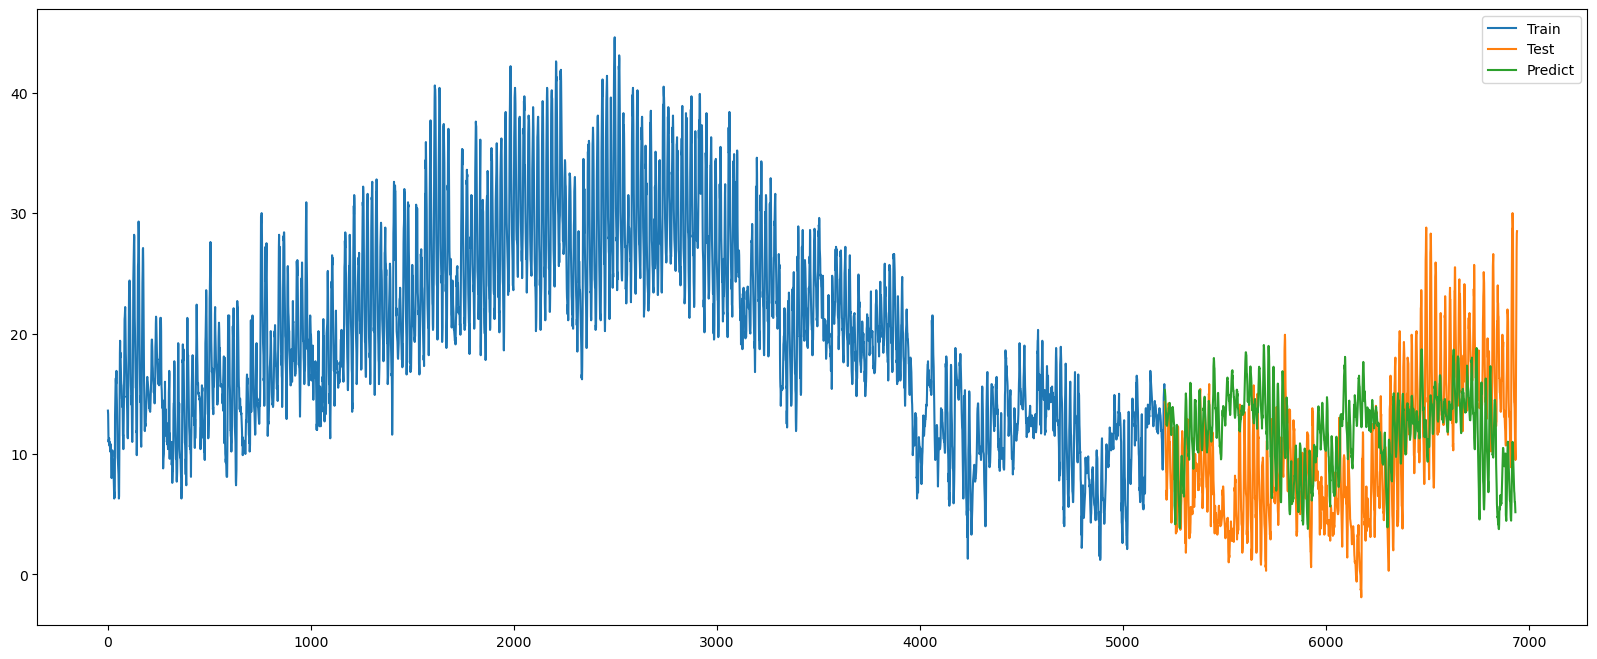

In [16]:
### Final plot with actual values and predictions
fig, ax = plt.subplots(figsize = (20, 8))

# Scale back the data
col_idx = df.columns.get_loc('T')
t_mean = scaler.mean_[col_idx]
t_scale = scaler.scale_[col_idx]

rescaled_t = (df['T'] * t_scale) + t_mean
rescaled_t_train = (train_df['T'] * t_scale) + t_mean
rescaled_t_test = (test_df['T'] * t_scale) + t_mean
rescaled_t_pred = (tdf_wodl[0] * t_scale) + t_mean

# Training Data 
ax.plot(np.arange(rescaled_t_train.shape[0]), rescaled_t_train, label = 'Train')
ax.plot(np.arange(rescaled_t_train.shape[0] + rescaled_t_test.shape[0] - n_steps_in)[rescaled_t_train.shape[0]:], rescaled_t_test[n_steps_in:], label = 'Test')
ax.plot(np.arange(rescaled_t_train.shape[0] + rescaled_t_pred.shape[0])[rescaled_t_train.shape[0]:], rescaled_t_pred, label = 'Predict')

plt.legend(loc = 'upper right')
plt.show()

#### 2) Encoder-Decoder Method - Multivariate Multi Input (Parallel) Multistep Model

In [17]:
# Sliding Windows for LSTM - Parallel Inputs
def sliding_window_parallel(dataframe, n_steps_in, n_steps_out):
    """
    dataframe - Pandas dataframe containing the rows and columns
    n_steps_in - Number of time steps used for prediction
    n_steps_out - Number of time steps to predict
    """
    
    # Local variables
    X, y = list(), list()
    
    for i in range(len(dataframe)):
        # Calculate indexes
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out
        
        # Exit condition
        if out_end_idx > len(dataframe): break
        
        # Slice sequence
        seq_x, seq_y = dataframe.iloc[i:end_idx, :], dataframe.iloc[end_idx:out_end_idx, 1:] # Ignoring the time column
        
        X.append(seq_x)
        y.append(seq_y)
            
    return np.array(X), np.array(y)

In [18]:
# Step parameters
n_steps_in = 512
n_steps_out = 24
n_features = len(df.columns) 

# Split data into train and test
train_size = int(len(df) * 0.75)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size - n_steps_in:].reset_index(drop = True) # Adjusting test size to account for lost steps.

train_X, train_y = sliding_window_parallel(train_df, n_steps_in, n_steps_out)
test_X, test_y = sliding_window_parallel(test_df, n_steps_in, n_steps_out)


# Verify Shapes for LSTM model
print("Train X: ",train_X.shape)
print("Train Y: ",train_y.shape)
print("Test X: ",test_X.shape)
print("Test Y: ",test_y.shape)

Train X:  (4670, 512, 13)
Train Y:  (4670, 24, 12)
Test X:  (1713, 512, 13)
Test Y:  (1713, 24, 12)


In [19]:
# Build
model = Sequential()
model.add(LSTM(units = 256, input_shape = (n_steps_in, n_features), dropout = 0.4)) # Encoder
model.add(RepeatVector(n_steps_out))
model.add(LSTM(units = 256, dropout = 0.4, return_sequences = True)) # Decoder
model.add(TimeDistributed(Dense(n_features - 1))) # -1 for Time Column
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 24, 256)          0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 24, 256)           525312    
                                                                 
 time_distributed (TimeDistr  (None, 24, 12)           3084      
 ibuted)                                                         
                                                                 
Total params: 804,876
Trainable params: 804,876
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile and Train
def decay_schedule(epoch, lr):
    if (epoch % 50 == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

model.compile(loss = 'mean_squared_error', optimizer = 'Adam')
K.set_value(model.optimizer.learning_rate, 0.005)
lr_scheduler = LearningRateScheduler(decay_schedule)
model.fit(train_X, train_y, epochs = 200, batch_size = 128, callbacks = [lr_scheduler])

Epoch 1/200
37/37 [==============================] - 5s 63ms/step - loss: 0.7010 - lr: 0.0050
Epoch 2/200
37/37 [==============================] - 2s 63ms/step - loss: 0.5983 - lr: 0.0050
Epoch 3/200
37/37 [==============================] - 2s 63ms/step - loss: 0.4748 - lr: 0.0050
Epoch 4/200
37/37 [==============================] - 2s 63ms/step - loss: 0.4165 - lr: 0.0050
Epoch 5/200
37/37 [==============================] - 2s 63ms/step - loss: 0.3581 - lr: 0.0050
Epoch 6/200
37/37 [==============================] - 2s 63ms/step - loss: 0.3219 - lr: 0.0050
Epoch 7/200
37/37 [==============================] - 2s 63ms/step - loss: 0.2705 - lr: 0.0050
Epoch 8/200
37/37 [==============================] - 2s 63ms/step - loss: 0.2394 - lr: 0.0050
Epoch 9/200
37/37 [==============================] - 2s 62ms/step - loss: 0.2496 - lr: 0.0050
Epoch 10/200
37/37 [==============================] - 2s 63ms/step - loss: 0.2227 - lr: 0.0050
Epoch 11/200
37/37 [==============================] - 2s 63

In [21]:
### Without data leakage, multi step prediction

y_preds_wodl = []
test_X_flat = np.reshape(test_X, (test_X.shape[0] * test_X.shape[1], test_X.shape[2]))
curr_idx = 0

for i in range(test_X_flat.shape[0]):
    # Exit Condition
    if curr_idx >= (test_X_flat.shape[0] // n_steps_in):
      break
    
    input = test_X_flat[curr_idx:curr_idx + n_steps_in]
    pred = model.predict(np.reshape(input, (-1, input.shape[0], input.shape[1])))
    test_X_flat[curr_idx + n_steps_in:curr_idx + n_steps_in + n_steps_out, 1:] = pred
    curr_idx += n_steps_out
    
    y_preds_wodl.extend(pred[0])

y_preds_wodl = np.array(y_preds_wodl)
y_preds_wodl = y_preds_wodl.reshape(y_preds_wodl.shape[0], -1)
tdf_wodl = pd.DataFrame(y_preds_wodl, np.arange(len(y_preds_wodl)))

1/1 [==============================] - 0s 22ms/step


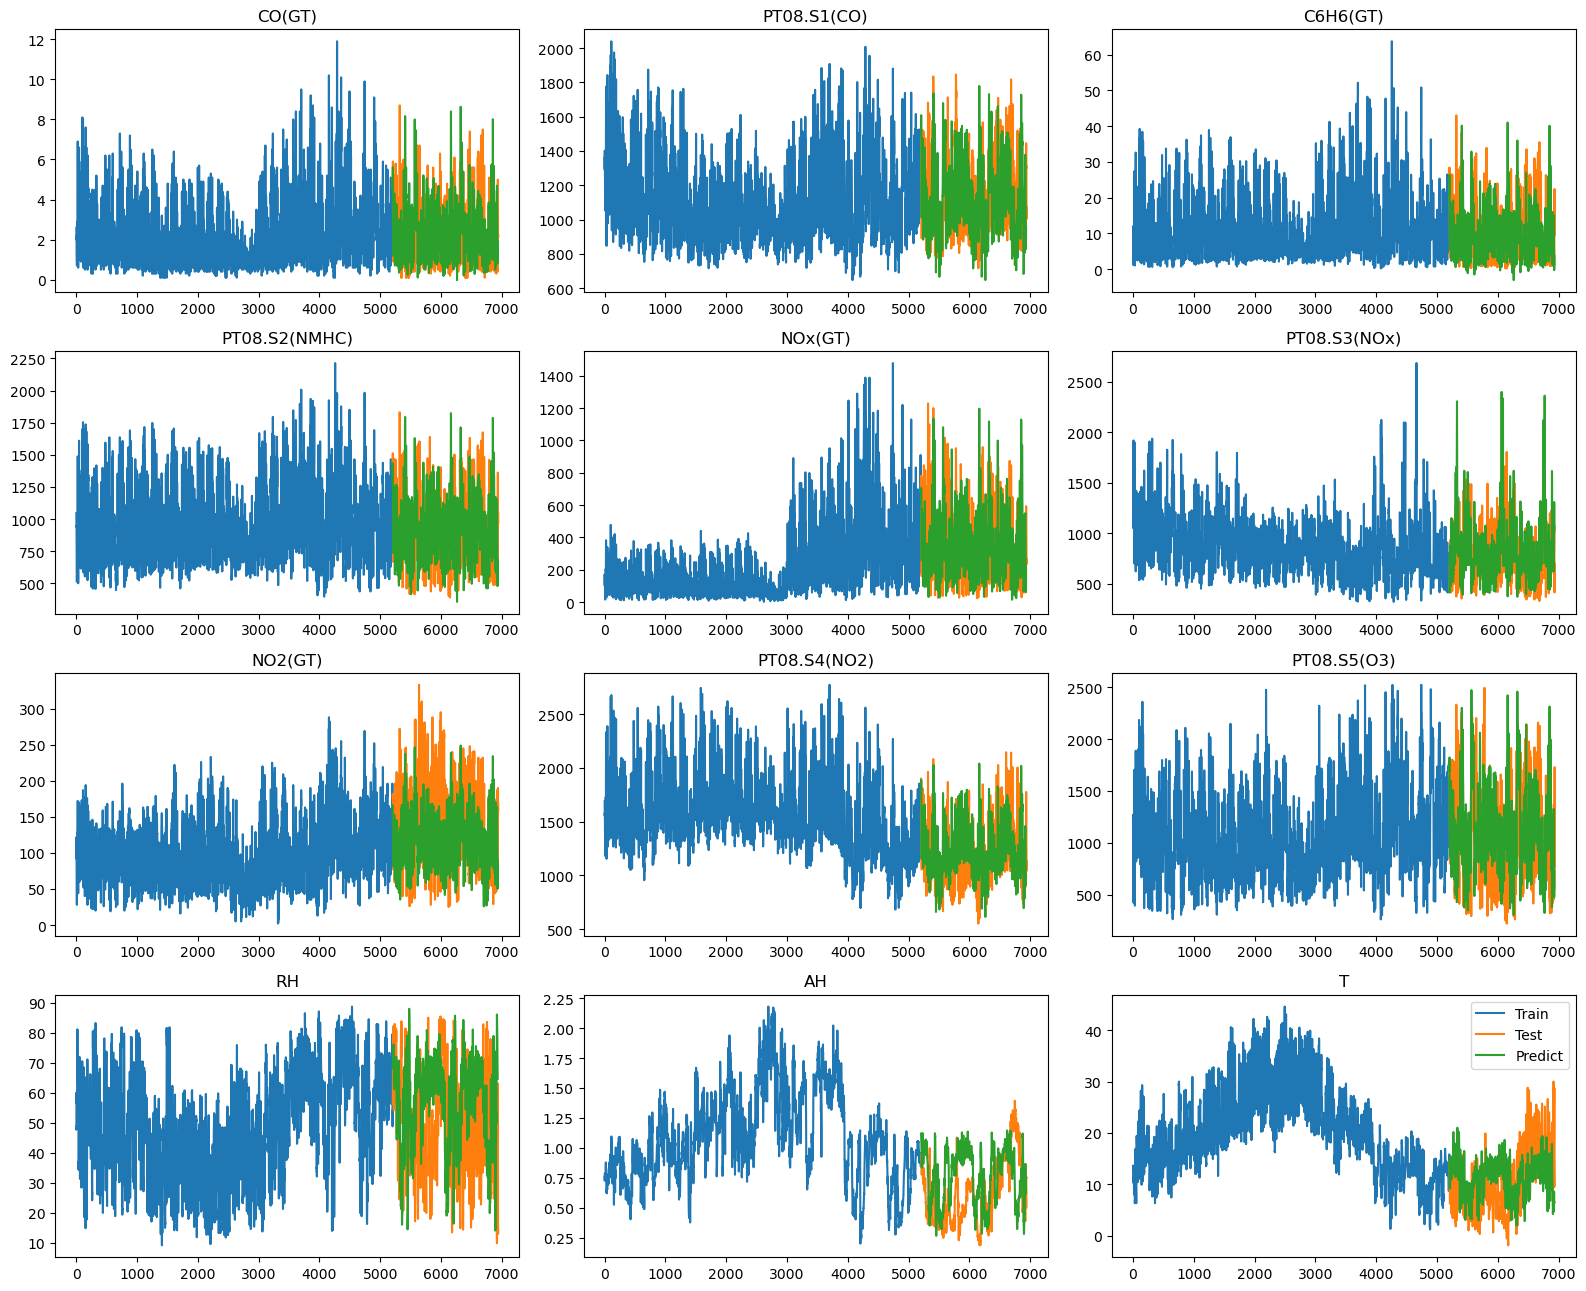

In [22]:
### Final plot with actual values and predictions

# Scale back the data
rescaled_df = scaler.inverse_transform(df)
rescaled_train = scaler.inverse_transform(train_df)[:, 1:]
rescaled_test = scaler.inverse_transform(test_df)[:, 1:]

column_mean = scaler.mean_[1:]
column_scale = scaler.scale_[1:]
rescaled_pred = np.array((tdf_wodl * column_scale) + column_mean)

# Plots for each feature
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (16, 16))
axes = axes.flatten()

for i, column in enumerate(df.drop(columns = ['Time']).columns):
    axes[i].plot(np.arange(rescaled_train.shape[0]), rescaled_train[:, i], label = 'Train')
    axes[i].plot(np.arange(rescaled_train.shape[0] + rescaled_test.shape[0] - n_steps_in)[rescaled_train.shape[0]:], rescaled_test[n_steps_in:, i], label = 'Test')
    axes[i].plot(np.arange(rescaled_train.shape[0] + rescaled_pred.shape[0])[rescaled_train.shape[0]:], rescaled_pred[:, i], label = 'Predict')
    axes[i].set_title(column)

if len(df.columns) - 1 < len(axes):
    for j in range(len(df.columns) - 1, len(axes)):
        fig.delaxes(axes[j])

# Adjust subplot spacing
fig.tight_layout()

# Show the plot
plt.legend(loc = 'upper right')
plt.show()